This notebook is supplementary material for the paper "A simple Condorcet voting method for Final Four elections" by Wesley H. Holliday (wesholliday@berkeley.edu).

It contains code to generate (1) the percentages in Figure 1, (2) the percentages in Table 1, (3) violations of independence of clones by IRV under the weak notion of clones claimed in Footnote 21, and (4) the estimated frequency of heavy top cycles referenced in Footnote 22.

In [1]:
#!pip3 install pref_voting

import pref_voting

from pref_voting.profiles import *
from pref_voting.voting_methods import *
from pref_voting.combined_methods import *
from pref_voting.margin_based_methods import *

from pref_voting.generate_profiles import generate_profile 
from pref_voting.generate_weighted_majority_graphs import generate_edge_ordered_tournament_infinite_limit

from tqdm.notebook import tqdm

# 1. Figure 1 percentages

First we create networkx digraphs for the four tournament isomorphism types.

Linear order:


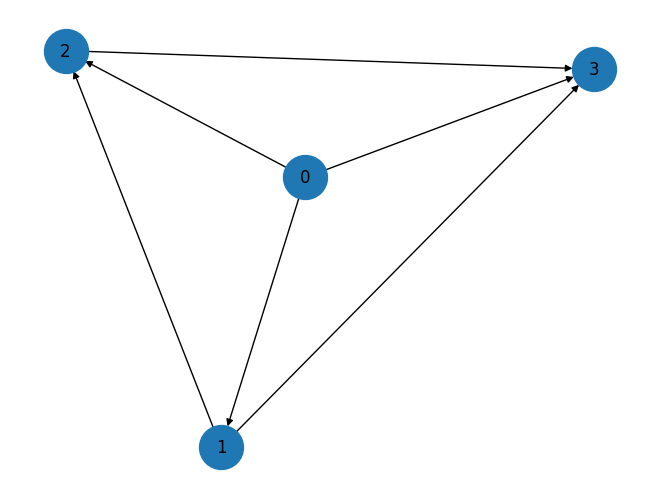

In [2]:
linear_order = nx.DiGraph()
linear_order.add_nodes_from(range(4))
linear_order.add_edges_from([(0,1),(0,2), (0,3), (1,2), (1,3), (2,3)]) 

print("Linear order:")
pos = nx.spring_layout(linear_order)
nx.draw(linear_order, pos, with_labels=True, node_size=1000)

Bottom cycle:


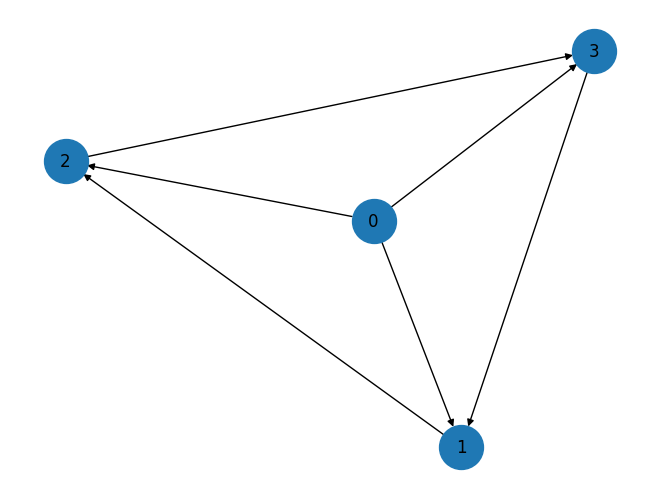

In [3]:
bottom_cycle = nx.DiGraph()
bottom_cycle.add_nodes_from(range(4))
bottom_cycle.add_edges_from([(0,1),(0,2), (0,3), (1,2), (2,3), (3,1)])

print("Bottom cycle:")
pos = nx.spring_layout(bottom_cycle)
nx.draw(bottom_cycle, pos, with_labels=True, node_size=1000)

Top cycle:


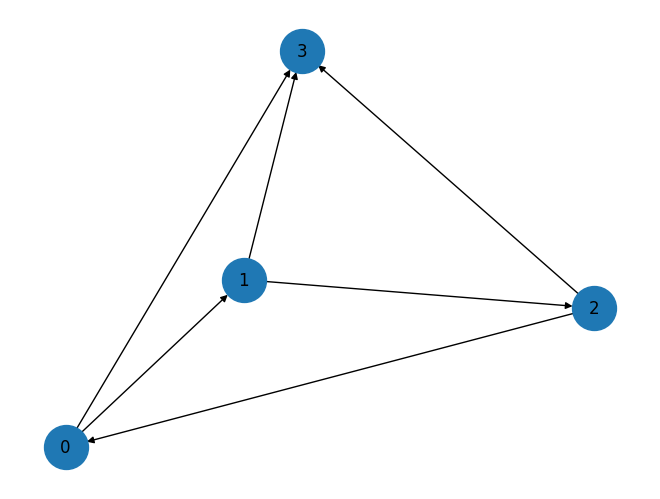

In [4]:
top_cycle = nx.DiGraph()
top_cycle.add_nodes_from(range(4))
top_cycle.add_edges_from([(0,1),(1,2), (2,0), (0,3), (1,3), (2,3)])

print("Top cycle:")
pos = nx.spring_layout(top_cycle)
nx.draw(top_cycle, pos, with_labels=True, node_size=1000)

Four cycle:


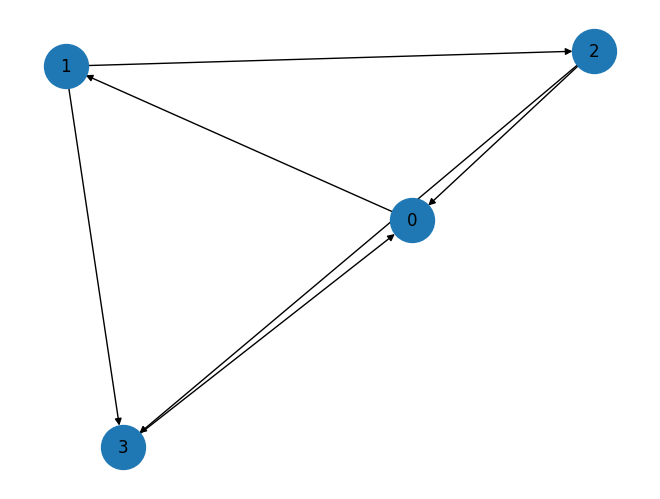

In [5]:
four_cycle = nx.DiGraph()
four_cycle.add_nodes_from(range(4))
four_cycle.add_edges_from([(0,1),(1,2), (2,3), (3,0), (2,0), (1,3)])

print("Four cycle:")
pos = nx.spring_layout(four_cycle)
nx.draw(four_cycle, pos, with_labels=True, node_size=1000)

In [6]:
num_trials = 100_000_000

linear_order_count = 0
bottom_cycle_count = 0
ascending_top_cycle_count = 0
descending_top_cycle_count = 0
SL_four_cycle_count = 0
LS_four_cycle_count = 0

for n in tqdm(range(num_trials)):

    mg = generate_edge_ordered_tournament_infinite_limit(4)

    # Extract the underlying directed graph from mg
    g = nx.DiGraph()
    g.add_nodes_from(range(4))
    directed_edges = [(a,b) for (a,b,c) in mg.edges]
    g.add_edges_from(directed_edges)

    # Find the appropriate isomorphism type
    if nx.is_isomorphic(g, linear_order):
        linear_order_count += 1

    if nx.is_isomorphic(g, bottom_cycle):
        bottom_cycle_count += 1

    if nx.is_isomorphic(g, top_cycle):

        top_cycle_cands = copeland(mg)
        assert len(top_cycle_cands) == 3

        # Find the candidate in the top cycle with the largest win
        max_margin_in_top_cycle = max([mg.margin(c1, c2) for c1 in top_cycle_cands for c2 in top_cycle_cands if c1 != c2])
        top_cycle_cands_with_largest_win = [c for c in top_cycle_cands if max([mg.margin(c, c2) for c2 in top_cycle_cands]) == max_margin_in_top_cycle]
        assert len(top_cycle_cands_with_largest_win) == 1
        top_cycle_cand_with_largest_win = top_cycle_cands_with_largest_win[0]

        # Find the candidate in the top cycle with the smallest loss
        min_pos_margin_in_top_cycle = min([mg.margin(c1, c2) for c1 in top_cycle_cands for c2 in top_cycle_cands if mg.margin(c1,c2) > 0])
        top_cycle_cands_with_smallest_loss = [c for c in top_cycle_cands if min([mg.margin(c2, c) for c2 in top_cycle_cands if mg.margin(c2,c) > 0]) == min_pos_margin_in_top_cycle]
        assert len(top_cycle_cands_with_smallest_loss) == 1
        top_cycle_cand_with_smallest_loss = top_cycle_cands_with_smallest_loss[0]

        if top_cycle_cand_with_smallest_loss != top_cycle_cand_with_largest_win:
            ascending_top_cycle_count += 1

        if top_cycle_cand_with_smallest_loss == top_cycle_cand_with_largest_win:
            descending_top_cycle_count += 1

    if nx.is_isomorphic(g, four_cycle):
        
        copeland_winners = copeland(mg)
        assert len(copeland_winners) == 2
        margin_between_copeland_winners = max([mg.margin(c1, c2) for c1 in copeland_winners for c2 in copeland_winners]) 
        margin_of_non_copeland_over_copeland = max([mg.margin(c, c2) for c in mg.candidates if c not in copeland_winners for c2 in copeland_winners])

        if margin_of_non_copeland_over_copeland < margin_between_copeland_winners:
            SL_four_cycle_count += 1

        if margin_of_non_copeland_over_copeland > margin_between_copeland_winners:
            LS_four_cycle_count += 1

print("Linear order:", (linear_order_count / num_trials) * 100, "%")
print("Bottom cycle:", (bottom_cycle_count / num_trials) * 100, "%")
print("Ascending top cycle:", (ascending_top_cycle_count / num_trials) * 100, "%")
print("Descending top cycle:", (descending_top_cycle_count / num_trials) * 100, "%")
print("SL four cycle:", (SL_four_cycle_count / num_trials) * 100, "%")
print("LS four cycle:", (LS_four_cycle_count / num_trials) * 100, "%")

  0%|          | 0/100000000 [00:00<?, ?it/s]

Linear order: 73.94676700000001 %
Bottom cycle: 8.507026 %
Ascending top cycle: 4.250127 %
Descending top cycle: 4.258751999999999 %
SL four cycle: 5.130765 %
LS four cycle: 3.906563 %


# 2. Table 1: frequency of disagreement with other methods

In [7]:
@vm(name = "Proposed Method")
def proposed_method(edata, curr_cands = None):

    copeland_winners = copeland(edata)

    worst_loss = dict()

    for c in copeland_winners:
        worst_loss[c] = max([edata.margin(c2, c) for c2 in edata.candidates])

    smallest_worst_loss = min(worst_loss.values())
    copeland_winners_with_smallest_worst_loss = [c for c in copeland_winners if worst_loss[c] == smallest_worst_loss]

    return copeland_winners_with_smallest_worst_loss

In [8]:
num_trials = 10_000_000

num_diff_with_rp = 0
num_diff_with_mm = 0
num_diff_with_smm = 0
num_diff_with_bp = 0
num_diff_with_sv = 0
num_diff_with_rv = 0
num_diff_with_km = 0


for n in tqdm(range(num_trials)):

    mg = generate_edge_ordered_tournament_infinite_limit(4)

    pm = proposed_method(mg)
    rp = ranked_pairs(mg)
    mm = minimax(mg)
    smm = smith_minimax(mg)
    bp = beat_path(mg)
    sv = stable_voting(mg)
    rv = river(mg)

    if pm != rp:
        num_diff_with_rp += 1

    if pm != mm:
        num_diff_with_mm += 1

    if pm != smm:
        num_diff_with_smm += 1

    if pm != bp:
        num_diff_with_bp += 1

    if pm != sv:
        num_diff_with_sv += 1

    if pm != rv:
        num_diff_with_rv += 1

print("Frequency of disagreement with Beat Path:", (num_diff_with_bp / num_trials) * 100, "%")
print("Frequency of disagreement with Minimax:", (num_diff_with_mm / num_trials) * 100, "%")
print("Frequency of disagreement with Ranked Pairs:", (num_diff_with_rp / num_trials) * 100, "%")
print("Frequency of disagreement with River:", (num_diff_with_rv / num_trials) * 100, "%")
print("Frequency of disagreement with Smith Minimax:", (num_diff_with_smm / num_trials) * 100, "%")
print("Frequency of disagreement with Stable Voting:", (num_diff_with_sv / num_trials) * 100, "%")

  0%|          | 0/10000000 [00:00<?, ?it/s]

Frequency of disagreement with Beat Path: 1.60836 %
Frequency of disagreement with Minimax: 1.7306 %
Frequency of disagreement with Ranked Pairs: 2.25313 %
Frequency of disagreement with River: 1.7904900000000001 %
Frequency of disagreement with Smith Minimax: 1.6430099999999999 %
Frequency of disagreement with Stable Voting: 1.56088 %


In [9]:
num_trials = 100_000
num_diff_with_irv = 0

for n in tqdm(range(num_trials)):
    prof = generate_profile(4, 1000)

    if proposed_method(prof) != instant_runoff(prof):
        num_diff_with_irv += 1

print("Frequency of disagreement with IRV:", (num_diff_with_irv / num_trials) * 100, "%")

  0%|          | 0/100000 [00:00<?, ?it/s]

Frequency of disagreement with IRV: 17.022000000000002 %


# 3. Footnote 21: IRV violates independence of clones with the weak notion of clones

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 0 |
| 3 | 3 | 3 | 1 | 2 |
| 2 | 2 | 1 | 0 | 3 |
| 1 | 0 | 0 | 2 | 1 |
+---+---+---+---+---+


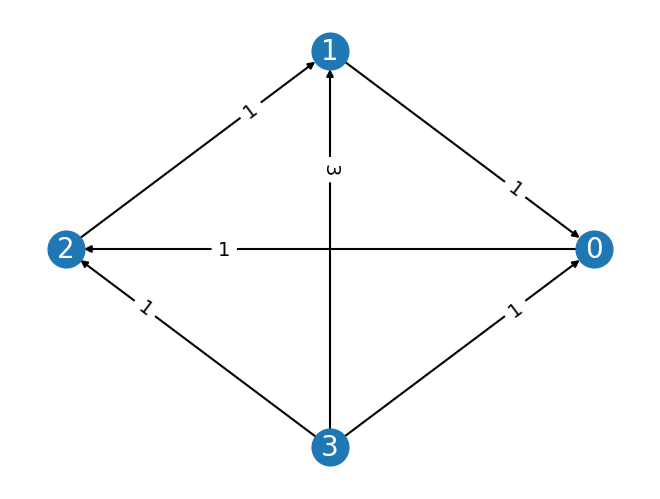

IRV winner: [0]
IRV winners after removing 0: [3]


In [10]:
num_trials = 1000

for n in range(num_trials):
    prof = generate_profile(4, 5)
    mg = prof.margin_graph()
    
    g = nx.DiGraph()
    g.add_nodes_from(range(4))
    directed_edges = [(a,b) for (a,b,c) in mg.edges]
    g.add_edges_from(directed_edges)

    irvws = instant_runoff(prof)

    if nx.is_isomorphic(g, bottom_cycle) and len(irvws) == 1:
        cw = condorcet(mg)[0]

        if cw not in irvws:
            bottom_cycle_cands = [c for c in prof.candidates if c != cw]

            found_ex = False

            for c in bottom_cycle_cands:
                new_irvws = instant_runoff(prof, curr_cands = [d for d in prof.candidates if d != c])
                if cw in new_irvws:
                    prof.display()
                    prof.display_margin_graph()
                    print("IRV winner:", irvws)
                    print(f"IRV winners after removing {c}:", new_irvws)
                    found_ex = True
                    break
            
            if found_ex:
                break     

# 4. Footnote 22: frequency of heavy top cycles

In [11]:
num_trials = 10_000_000

heavy_top_cycle = 0

for n in tqdm(range(num_trials)):
    mg = generate_edge_ordered_tournament_infinite_limit(4)
    
    mm = minimax(mg)[0]
    if mg.copeland_scores()[mm] == -3:
        heavy_top_cycle += 1

print("Heavy top cycle:", (heavy_top_cycle / num_trials) * 100, "%")

  0%|          | 0/10000000 [00:00<?, ?it/s]

Heavy top cycle: 0.08685999999999999 %
